# Results visualization notebook

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


In [11]:
img = cv2.imread('./data/rgb/1305031102.175304.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

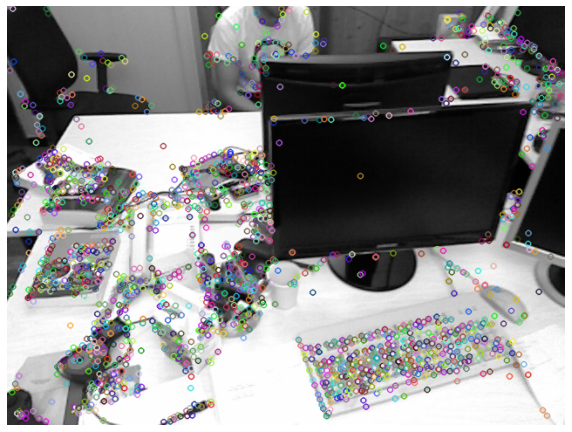

In [17]:
kp, dsc = sift.detectAndCompute(gray, None)
img_with_kp = cv2.drawKeypoints(gray, kp)
plt.figure(figsize=(10, 10))
plt.imshow(img_with_kp)
plt.axis('off');

In [82]:
class TUM_dataset():
    def __init__(self, path='./data', step=5):
        images = [cv2.imread(path + '/rgb/' + im) for im in tqdm(os.listdir(path + '/rgb')[::step])]
        
        # build raw keypoints and descriptors data
        sift = cv2.SIFT_create()
        self.pts_n_dsc = [sift.detectAndCompute(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), None) for im in images]
                  
        # build pairs of images to find correspondences
        self.data = list(zip(images[:-1],
                             images[1:]))
                  
    def get_sift_data(self, i):
        return (self.pts_n_dsc[i], self.pts_n_dsc[i+1])
                  
    def __getitem__(self, i):
        return self.data[i]
      
    def __len__(self):
        return len(self.data)
    
def show_pair_ims(pair):
    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(pair[0])
    axs[0].axis('off');
    axs[1].imshow(pair[1])
    axs[1].axis('off');

In [83]:
data_loader = TUM_dataset()

100%|██████████| 160/160 [00:01<00:00, 97.85it/s] 


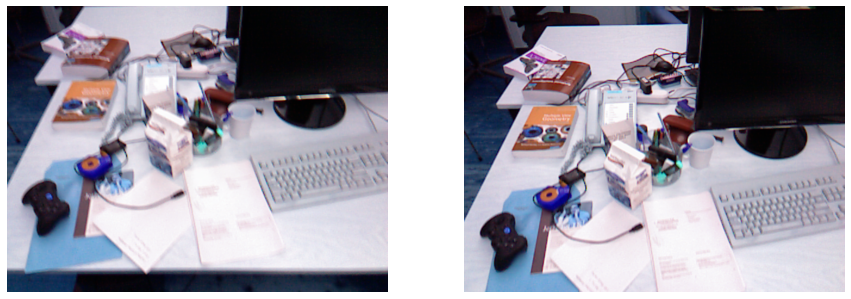

In [93]:
idx = 1#np.random.choice(len(data_loader))
im_left, im_right = data_loader[idx]
show_pair_ims((im_left, im_right))

## SIFT: detect keypoints and create descriptors

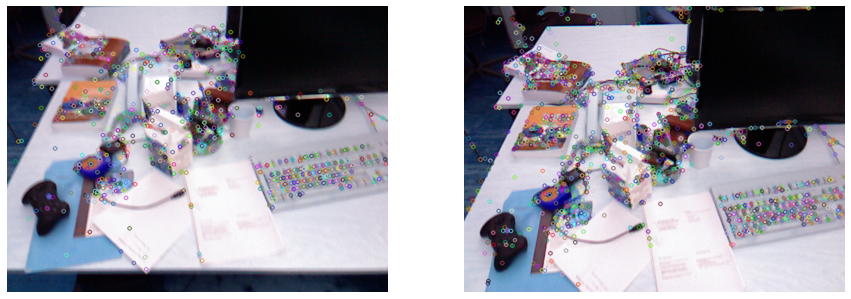

In [98]:
sift_left, sift_right = data_loader.get_sift_data(1)
sift_left_im = cv2.drawKeypoints(im_left, sift_left[0], _)
sift_right_im = cv2.drawKeypoints(im_right, sift_right[0], _)
show_pair_ims((sift_left_im, sift_right_im))

## KNN Matcher

In [159]:
def to_cv_dmatch(match_indices):
    return list(map(lambda x: cv2.DMatch(x[0], x[1], 0, 0), zip(np.arange(0, len(match_indices)), match_indices)))

In [166]:
k = 1
corrs = np.zeros(len(sift_left[0]), dtype=int)
for i, pt_l in enumerate(sift_left[0]):
    dsc_l = sift_left[1][i]
    dists = []
    for j, pt_r in enumerate(sift_right[0]):
        dsc_r = sift_right[1][j]
        dists.append(np.linalg.norm(dsc_l - dsc_r, ord=2))
    
    corrs[i] = np.argsort(np.array(dists))[0]


In [167]:
img_with_matches = cv2.drawMatches(im_left, sift_left[0], im_right, sift_right[0], 
                                   to_cv_dmatch(corrs), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

(-0.5, 1279.5, 479.5, -0.5)

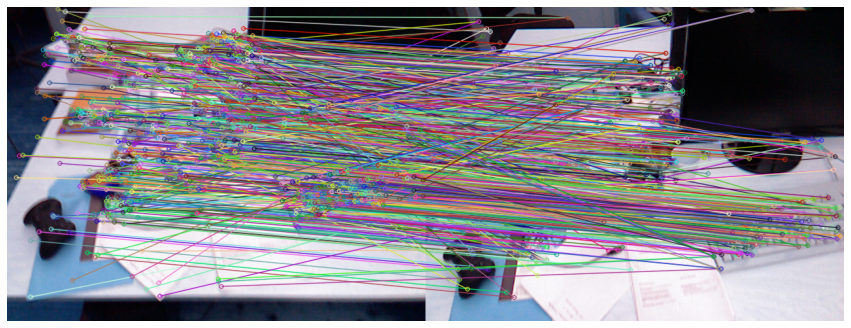

In [168]:
plt.figure(figsize=(15, 15))
plt.imshow(img_with_matches)
plt.axis('off')

## [AdaLam](https://github.com/cavalli1234/AdaLAM) Outlier Filtering


